In [61]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import sys
import os
from torch.utils.data import DataLoader
import yaml

In [62]:
# compactly add project src and analysis/zero-shot to sys.path if not already present
for rel in ('src', 'analysis/forecasting'):
    p = os.path.abspath(os.path.join(os.getcwd(), rel))
    if p not in sys.path:
        sys.path.append(p)

# now imports that rely on those paths
from utils import SequentialDeepONetDataset
from helper import convert2dim, compute_metrics_region, load_model_experiment_dropout, plot_field_region, fit, init_model_dropout

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


## Load Datasets

In [63]:
input_data = np.load('data/neutron_data_22yrs.npy')
trunk = np.load('data/grid_points.npy')
target = np.load('data/dose_array.npy')

print("Input data shape:", input_data.shape)
print("Trunk shape:", trunk.shape)
print("Target shape:", target.shape)

Input data shape: (8400, 12)
Trunk shape: (65341, 2)
Target shape: (8400, 65341)


In [64]:
from forecasting_analysis import create_windows_forecasting_with_index

In [65]:
dates = pd.date_range("2001-01-01", "2023-12-31", freq="D")

W, H = 30, 1
X_all, y_all, tgt_idx = create_windows_forecasting_with_index(input_data, target, W, H)
tgt_dates = dates[tgt_idx]

train_mask = (tgt_dates <= pd.Timestamp("2021-12-31"))
val_mask   = (tgt_dates >= pd.Timestamp("2022-01-01")) & (tgt_dates <= pd.Timestamp("2022-12-31"))
test_mask  = (tgt_dates >= pd.Timestamp("2023-01-01")) & (tgt_dates <= pd.Timestamp("2023-12-31"))

X_train, y_train = X_all[train_mask], y_all[train_mask]
X_val,   y_val   = X_all[val_mask],   y_all[val_mask]
X_test,  y_test  = X_all[test_mask],  y_all[test_mask]

# check shapes
print("Train set:", X_train.shape, y_train.shape)
print("Validation set:", X_val.shape, y_val.shape)
print("Test set:", X_test.shape, y_test.shape)

Train set: torch.Size([7640, 30, 12]) torch.Size([7640, 65341])
Validation set: torch.Size([365, 30, 12]) torch.Size([365, 65341])
Test set: torch.Size([365, 30, 12]) torch.Size([365, 65341])


In [66]:
scaler_input = MinMaxScaler()
X_train_scaled = scaler_input.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
X_val_scaled   = scaler_input.transform(X_val.reshape(-1, X_val.shape[-1])).reshape(X_val.shape)
X_test_scaled  = scaler_input.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

In [67]:
# Fit on ALL training pixels (flattened)
scaler_target = MinMaxScaler()

# Transform sets
y_train_scaled = scaler_target.fit_transform(y_train)[..., np.newaxis]
y_val_scaled   = scaler_target.transform(y_val)[..., np.newaxis]
y_test_scaled  = scaler_target.transform(y_test)[..., np.newaxis]

In [68]:
# create datasets
train_dataset = SequentialDeepONetDataset(X_train_scaled, trunk, y_train_scaled)
val_dataset   = SequentialDeepONetDataset(X_val_scaled,   trunk, y_val_scaled)
test_dataset  = SequentialDeepONetDataset(X_test_scaled,  trunk, y_test_scaled)

# create dataloaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

## TRON

In [69]:
from forecasting_analysis import train_model

In [166]:
NUM_MODELS = 5  # typical: 3–10
# models = []
# 
# for seed in range(NUM_MODELS):
#     torch.manual_seed(seed + 12345)
#     np.random.seed(seed + 12345)
#     
#     print(f"Training model {seed+1}/{NUM_MODELS} with seed {seed}")
# 
#     model_k = init_model_dropout()
#     model_k = model_k.to(device)
# 
#     history = train_model(
#         model=model_k,
#         train_loader=train_loader,
#         val_loader=val_loader,
#         device=device,
#         num_epochs=300,
#         lr=1e-3,
#         weight_decay=1e-3,
#         scheduler_step=20,
#         scheduler_gamma=0.7,
#         early_stop_patience=20,
#         save_path=f"analysis/forecasting/ensemble/model_ensemble_{seed}.pt"
#     )
# 
#     print(f"Model {seed+1} training complete.")
# 
# print("All models trained and saved.")

In [184]:
model = load_model_experiment_dropout(model_path = 'analysis/forecasting/ensemble/model_ensemble_base.pt')
model = model.to(device)

Loaded model from analysis/forecasting/ensemble/model_ensemble_base.pt


/projects/bcnx/kazumak2/CosmicRays-Operator/src/helper.py:148: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


In [181]:
import torch
import numpy as np

@torch.no_grad()
def fit_mc_dropout_per_feature(
    model,
    data_loader,
    device,
    scaler_target,        # MinMaxScaler fit on (N_train, 65341) -> per-feature mins/maxes
    n_samples=30,
    clamp=True            # clamp mean z to [0,1] before inverse-scaling
):
    """
    MC-Dropout inference with per-feature MinMax scaling.
    Assumes targets/preds are aligned to the SAME 1° grid columns used to fit the scaler.
    
    Returns:
        mean_phys : (N, M)  inverse-scaled ensemble mean
        std_phys  : (N, M)  inverse-scaled ensemble std  (scaled by per-feature (max-min))
        tgt_phys  : (N, M)  inverse-scaled ground truth
    """
    # Activate dropout masks but keep gradients off
    model.train()

    mc_batches = []   # list of [S, B, M]
    tgt_batches = []  # list of [B, M]
    for branch_batch, trunk_batch, target_batch in data_loader:
        branch_batch = branch_batch.to(device, non_blocking=True)
        trunk_batch  = trunk_batch.to(device,  non_blocking=True)
        target_batch = target_batch.to(device, non_blocking=True)

        # S stochastic forward passes with dropout
        samp = []
        for _ in range(n_samples):
            y = model(branch_batch, trunk_batch)           # [B, M] or [B, M, 1]
            y = y.detach().squeeze(-1).cpu()               # [B, M]
            samp.append(y.unsqueeze(0))                    # [1, B, M]
        mc_batches.append(torch.cat(samp, dim=0))          # [S, B, M]
        tgt_batches.append(target_batch.detach().squeeze(-1).cpu())  # [B, M]

    # Stack across batches -> [S, N, M] and [N, M]
    mc_all = torch.cat(mc_batches, dim=1)     # [S, N, M]
    tgt_all = torch.cat(tgt_batches, dim=0)   # [N, M]

    # Mean/Std over samples (dim=0)
    mean_z = mc_all.mean(dim=0).numpy()       # [N, M] in scaled space
    std_z  = mc_all.std(dim=0).numpy()        # [N, M] in scaled space
    tgt_z  = tgt_all.numpy()                  # [N, M] in scaled space

    # Optional clamp before inverse-scaling (prevents extrapolation with MinMax)
    if clamp:
        mean_z = np.clip(mean_z, 0.0, 1.0)

    # Per-feature inverse scaling
    mean_phys = scaler_target.inverse_transform(mean_z)    # [N, M]
    tgt_phys  = scaler_target.inverse_transform(tgt_z)     # [N, M]

    # Std transforms linearly with MinMax: y = z*(max-min)+min  ->  σ_y = σ_z*(max-min)
    scale_vec = (scaler_target.data_max_ - scaler_target.data_min_)  # shape [M]
    std_phys  = std_z * scale_vec.reshape(1, -1)                     # broadcast to [N, M]

    return mean_phys, std_phys, tgt_phys


In [187]:
mean_phys, std_phys, tgt_phys = fit_mc_dropout_per_feature(
    model, test_loader, device, scaler_target, n_samples=50, clamp=False
)


In [178]:
# ---- load YAML (list of dicts) ----
with open("analysis/forecasting/yaml/city_columns.yaml", "r", encoding="utf-8") as f:
    cities = yaml.safe_load(f)

# ---- unpack fields ----
names = [c["name"] for c in cities]
cols  = np.array([int(c["col"])   for c in cities], dtype=np.int64)
lat_i = np.array([int(c["lat_i"]) for c in cities], dtype=np.int16)
lon_i = np.array([int(c["lon_i"]) for c in cities], dtype=np.int16)

print("Names:", names)
print("Cols:", cols.shape, "Lat/Lon:", lat_i.shape, lon_i.shape)


Names: ['New_York', 'San_Francisco', 'São_Paulo', 'London', 'Helsinki', 'Cairo', 'Johannesburg', 'Riyadh', 'Delhi', 'Tokyo', 'Jakarta', 'Sydney']
Cols: (12,) Lat/Lon: (12,) (12,)


New_York (col 19317): Spearman ρ = 0.7494
San_Francisco (col 10626): Spearman ρ = 0.7483
São_Paulo (col 24139): Spearman ρ = 0.7476
London (col 32722): Spearman ρ = 0.7494
Helsinki (col 37255): Spearman ρ = 0.7477
Cairo (col 38311): Spearman ρ = 0.7483
Johannesburg (col 37712): Spearman ρ = 0.7486
Riyadh (col 41202): Spearman ρ = 0.7491
Delhi (col 46636): Spearman ρ = 0.7482
Tokyo (col 58046): Spearman ρ = 0.7475
Jakarta (col 52031): Spearman ρ = 0.7483
Sydney (col 59967): Spearman ρ = 0.7476


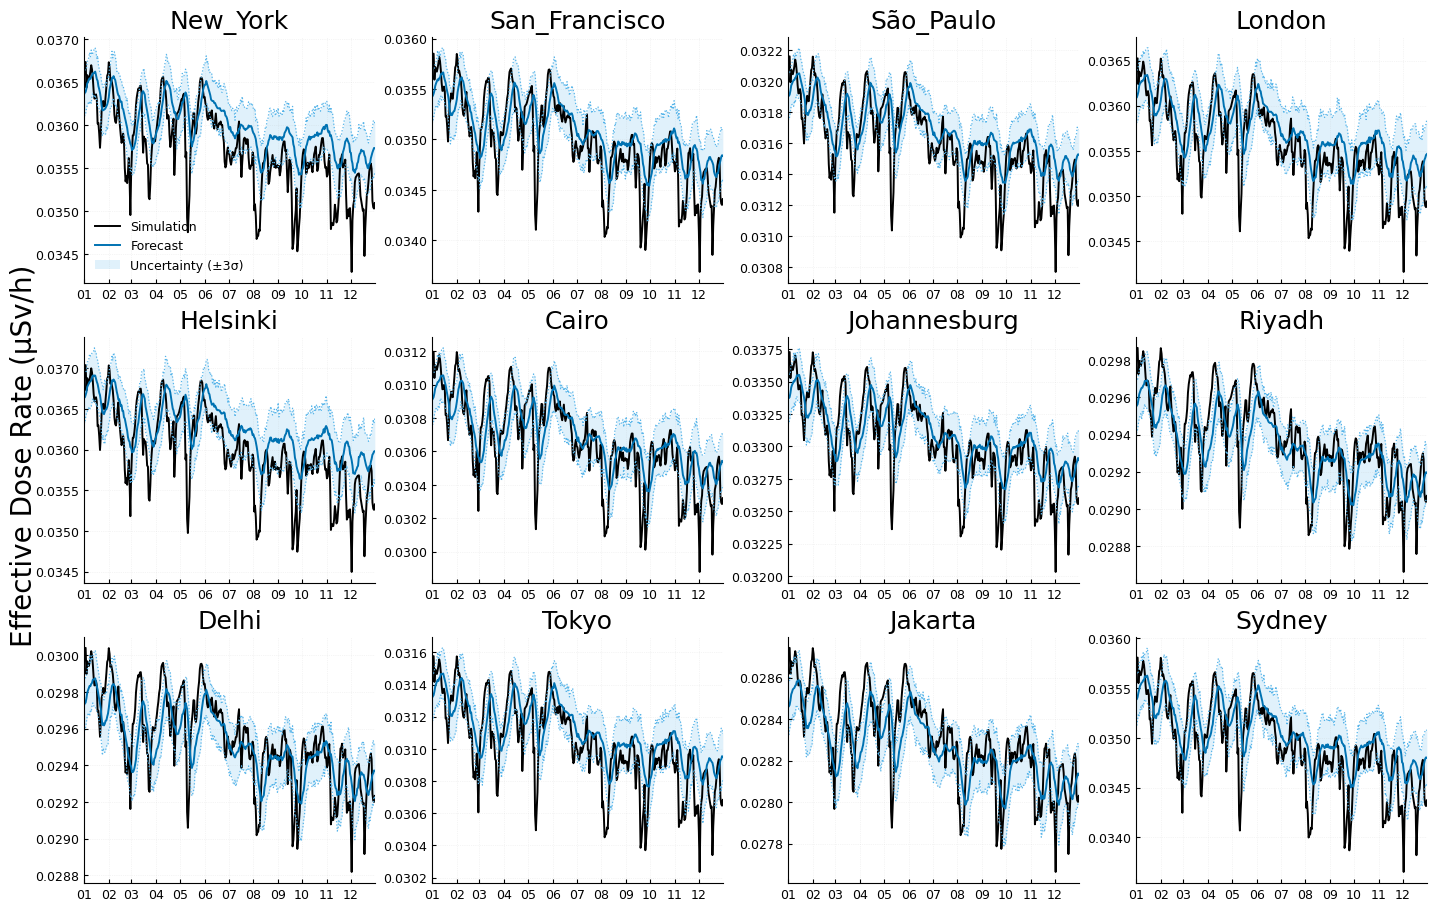

In [192]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mticker
import numpy as np
from scipy.stats import spearmanr

# ============================================================
# CONFIGURATION
# ============================================================

USE_GRAYSCALE = False   # switch True for print-safe grayscale
LINE_W = 1.4
BOUND_W = 0.9
ALPHA_BAND = 0.18

COLS = {
    "black": "#000000",
    "blue":  "#0072B2",
    "sky":   "#56B4E9",
}

plt.rcParams.update({
    "pdf.fonttype": 42,
    "ps.fonttype": 42,
    "font.size": 10,
    "axes.labelsize": 11,
    "axes.titlesize": 13,
    "legend.fontsize": 9,
    "savefig.dpi": 300,
})

# ============================================================
# FIGURE AND AXES
# ============================================================

fig, ax = plt.subplots(3, 4, figsize=(14, 9), constrained_layout=True)

month_locator = mdates.MonthLocator(bymonthday=1)
month_fmt     = mdates.DateFormatter('%m')  # "Jan", "Feb", ...

# ============================================================
# PLOTTING LOOP
# ============================================================

for i in range(len(names)):
    city_name = names[i]
    j         = cols[i]
    pred      = mean_phys[:, j]
    targ      = tgt_phys[:, j]
    sigma     = std_phys[:, j]
    dates     = tgt_dates[test_mask]

    # --- compute Spearman ρ ---
    rho, _ = spearmanr(pred, targ)
    print(f"{city_name} (col {j}): Spearman ρ = {rho:.4f}")

    axi = ax.flat[i]

    if USE_GRAYSCALE:
        axi.plot(dates, targ, color="black", linewidth=LINE_W, label="Simulation")
        axi.plot(dates, pred, color="black", linewidth=LINE_W, linestyle="--", label="Forecast")
        axi.fill_between(dates, pred-3*sigma, pred+3*sigma, color="0.70", alpha=0.25, linewidth=0)
        axi.plot(dates, pred-3*sigma, color="0.35", linestyle=":", linewidth=BOUND_W)
        axi.plot(dates, pred+3*sigma, color="0.35", linestyle=":", linewidth=BOUND_W)
    else:
        axi.plot(dates, targ, color=COLS["black"], linewidth=LINE_W, label="Simulation")
        axi.plot(dates, pred, color=COLS["blue"],  linewidth=LINE_W, label="Forecast")
        axi.fill_between(dates, pred-3*sigma, pred+3*sigma,
                         color=COLS["sky"], alpha=ALPHA_BAND, linewidth=0,
                         label="Uncertainty (±3σ)")
        axi.plot(dates, pred-3*sigma, color=COLS["sky"], linewidth=BOUND_W, linestyle=":")
        axi.plot(dates, pred+3*sigma, color=COLS["sky"], linewidth=BOUND_W, linestyle=":")

    # --- cosmetics ---
    axi.set_title(f"{city_name}", fontsize=18)
    #axi.set_xlabel("Month", fontsize=11)
    #axi.set_ylabel("Dose Rate (µSv/h)", fontsize=11)
    axi.set_xlim(dates[0], dates[-1])
    axi.xaxis.set_major_locator(month_locator)
    axi.xaxis.set_major_formatter(month_fmt)
    axi.xaxis.set_minor_locator(mticker.NullLocator())
    axi.grid(alpha=0.25, linestyle=":", linewidth=0.5)
    axi.spines['top'].set_visible(False)
    axi.spines['right'].set_visible(False)
    axi.tick_params(axis='both', direction='in', length=3, width=0.8, labelsize=9)

    # --- Spearman ρ annotation ---
    #axi.text(
    #    0.02, 0.93,
    #    f"ρ = {rho:.3f}",
    #    transform=axi.transAxes,
    #    fontsize=9,
    #    bbox=dict(boxstyle="round,pad=0.2", fc="white", ec="gray", alpha=0.8)
    #)

# ============================================================
# GLOBAL LABELS AND SAVE
# ============================================================

ax[0, 0].legend(loc="lower left", frameon=False)
#fig.suptitle("Forecasted vs Target Effective Dose Rate (2023)", fontsize=16)
#fig.text(0.5, 0.01, "Month of 2023", ha="center", fontsize=20)
fig.text(-0.015, 0.5, "Effective Dose Rate (µSv/h)", va="center", rotation="vertical", fontsize=20)
plt.savefig("analysis/forecasting/figures/forecast_mc_dropout_cities.png", bbox_inches="tight", dpi=300)
plt.show()


In [161]:
import numpy as np
from scipy.stats import spearmanr
from numpy import arctanh, tanh, sqrt

def metrics_one(pred, targ):
    mae  = np.mean(np.abs(pred - targ))
    rmse = np.sqrt(np.mean((pred - targ)**2))
    r    = np.corrcoef(pred, targ)[0,1]  # Pearson
    rho, _ = spearmanr(pred, targ)       # Spearman

    # Fisher z CI for Pearson (approx; for Spearman, use bootstrap if you want)
    n = len(pred)
    z  = arctanh(np.clip(r, -0.999999, 0.999999))
    se = 1/np.sqrt(max(n-3,1))
    z_lo, z_hi = z - 1.96*se, z + 1.96*se
    r_lo, r_hi = tanh(z_lo), tanh(z_hi)
    return dict(mae=mae, rmse=rmse, pearson=r, pearson_ci=(r_lo, r_hi), spearman=rho)

for i, name in enumerate(names):
    j = cols[i]
    m = metrics_one(mean_phys[:, j], tgt_phys[:, j])
    print(f"{name:15s}  MAE={m['mae']:.3e}  RMSE={m['rmse']:.3e}  "
          f"r={m['pearson']:.3f} [{m['pearson_ci'][0]:.3f},{m['pearson_ci'][1]:.3f}]  "
          f"ρ={m['spearman']:.3f}")




New_York         MAE=3.463e-04  RMSE=4.409e-04  r=0.728 [0.675,0.773]  ρ=0.747
San_Francisco    MAE=2.523e-04  RMSE=3.256e-04  r=0.727 [0.674,0.772]  ρ=0.746
São_Paulo        MAE=1.681e-04  RMSE=2.165e-04  r=0.728 [0.676,0.773]  ρ=0.747
London           MAE=2.921e-04  RMSE=3.748e-04  r=0.725 [0.673,0.771]  ρ=0.746
Helsinki         MAE=3.594e-04  RMSE=4.572e-04  r=0.728 [0.676,0.773]  ρ=0.746
Cairo            MAE=1.453e-04  RMSE=1.873e-04  r=0.728 [0.676,0.773]  ρ=0.748
Johannesburg     MAE=1.895e-04  RMSE=2.445e-04  r=0.727 [0.675,0.772]  ρ=0.747
Riyadh           MAE=1.363e-04  RMSE=1.709e-04  r=0.726 [0.674,0.772]  ρ=0.748
Delhi            MAE=1.359e-04  RMSE=1.716e-04  r=0.727 [0.674,0.772]  ρ=0.748
Tokyo            MAE=1.584e-04  RMSE=2.037e-04  r=0.727 [0.675,0.772]  ρ=0.747
Jakarta          MAE=1.239e-04  RMSE=1.545e-04  r=0.726 [0.673,0.771]  ρ=0.747
Sydney           MAE=2.515e-04  RMSE=3.239e-04  r=0.728 [0.676,0.773]  ρ=0.747


In [190]:
lon_grid, lat_grid, pred_img = convert2dim(mean_phys, grid_path='data/grid_points.npy')  # (N,H,W)
_,        _,        targ_img = convert2dim(tgt_phys, grid_path='data/grid_points.npy')  # (N,H,W)

print("Prediction image shape:", pred_img.shape)
print("Target image shape:", targ_img.shape)

Prediction image shape: (365, 181, 361)
Target image shape: (365, 181, 361)


In [191]:
l2, ssim = compute_metrics_region(pred_img, targ_img, lon_grid, lat_grid, region_extent=[-180, 180, -90, 90])

Region [-180, 180, -90, 90]
Mean rel-L2 (%): 0.8627433
Mean SSIM: 0.9975745976604066


In [102]:
# 365 days covering 2023 test period
dates = pd.date_range("2023-01-01", "2023-12-31", freq="D")

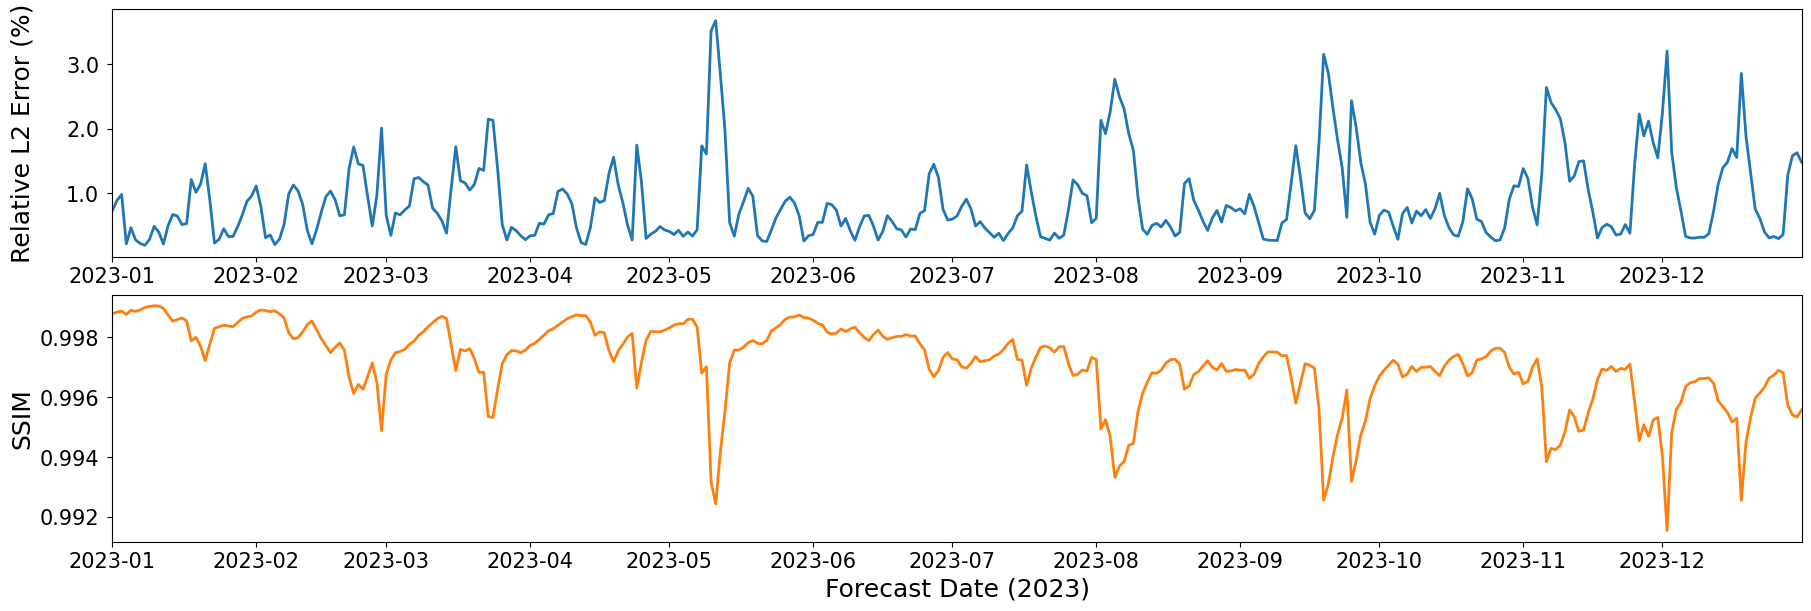

In [103]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mtick

fig, ax = plt.subplots(2, 1, figsize=(18, 6), sharex=True, constrained_layout=True)

# month ticks/labels (use '%b' for Jan/Feb..., or '%Y-%m' for 2023-01)
month_locator = mdates.MonthLocator(interval=1)
month_fmt = mdates.DateFormatter('%Y-%m')

# --- top: Relative L2 ---
ax[0].plot(dates, l2, lw=2, color='tab:blue')
ax[0].set_ylabel('Relative L2 Error (%)', fontsize=18)
ax[0].yaxis.set_major_formatter(mtick.FormatStrFormatter('%.1f'))

# --- bottom: SSIM ---
ax[1].plot(dates, ssim, lw=2, color='tab:orange')
ax[1].set_ylabel('SSIM', fontsize=18)
ax[1].set_xlabel('Forecast Date (2023)', fontsize=18)
ax[1].yaxis.set_major_formatter(mtick.FormatStrFormatter('%.3f'))

# apply the SAME x tick locator/formatter to BOTH axes
for a in ax:
    a.xaxis.set_major_locator(month_locator)
    a.xaxis.set_major_formatter(month_fmt)
    # <-- CRUCIAL: re-enable top-axis labels even with sharex
    a.tick_params(axis='x', which='both', labelbottom=True, rotation=0)
    a.yaxis.set_ticks_position('left')
    a.yaxis.set_label_position('left')
    a.tick_params(axis='y', pad=6)
    # thick font size for x and y ticks
    a.tick_params(axis='x', labelsize=15)
    a.tick_params(axis='y', labelsize=15)

# nice alignment and limits
fig.align_ylabels(ax)
ax[1].set_xlim(dates[0], dates[-1])

#plt.savefig('analysis/forecasting/forecast_metrics_2023.png', dpi=300)
plt.show()


In [79]:
# find 50th percentile dates for L2 and SSIM
l2_50th = np.percentile(l2, 50)
ssim_50th = np.percentile(ssim, 50)

idx_50pct = np.argmin(np.abs(l2 - l2_50th))
idx_50pct_ssim = np.argmin(np.abs(ssim - ssim_50th))

print("50th percentile Relative L2 Error: %.2f%% on %s" % (l2_50th, dates[idx_50pct].strftime('%Y-%m-%d')))
print("50th percentile SSIM: %.4f on %s" % (ssim_50th, dates[idx_50pct_ssim].strftime('%Y-%m-%d')))

# find the minimum ssim
min_ssim_idx = np.argmin(ssim)
print("Minimum SSIM: %.4f on %s" % (ssim[min_ssim_idx], dates[min_ssim_idx].strftime('%Y-%m-%d')))

50th percentile Relative L2 Error: 0.67% on 2023-09-02
50th percentile SSIM: 0.9973 on 2023-08-17
Minimum SSIM: 0.9915 on 2023-12-02


In [80]:
date = dates[min_ssim_idx]

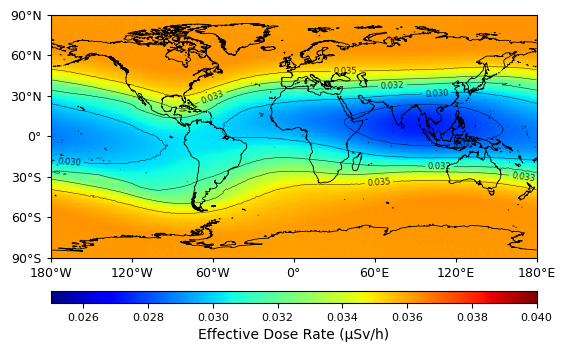

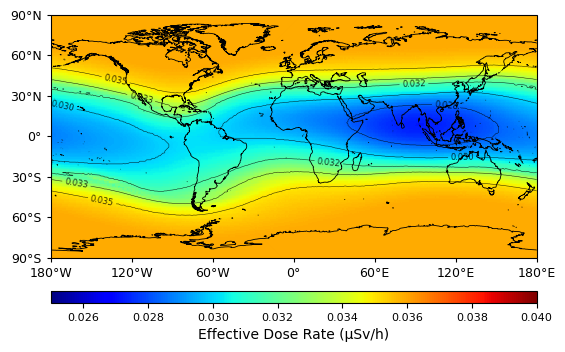

In [81]:
# convert index to date
date = dates[idx_50pct].date()

plot_field_region(
    lon_grid, lat_grid, pred_img, i=idx_50pct,
    #title=f"test {date}",
    units_label="Effective Dose Rate (µSv/h)",
    region_extent=[-180, 180, -90, 90],
    vmin=0.025, vmax=0.040,
    tick_step=(60, 30),
    add_contour=True, contour_levels=np.linspace(0.025, 0.040, 10),
    mark_equator_meridian=False,
    show_borders=False,
    cmap= 'jet',
    #savepath='analysis/forecasting/prediction_global.png'
)

plot_field_region(
    lon_grid, lat_grid, targ_img, i=idx_50pct,
    #title=f"test {date}",
    units_label="Effective Dose Rate (µSv/h)",
    region_extent=[-180, 180, -90, 90],
    vmin=0.025, vmax=0.040,
    tick_step=(60, 30),
    add_contour=True, contour_levels=np.linspace(0.025, 0.040, 10),
    mark_equator_meridian=False,
    show_borders=False,
    cmap= 'jet',
    #savepath='analysis/forecasting/target_global.png'
)

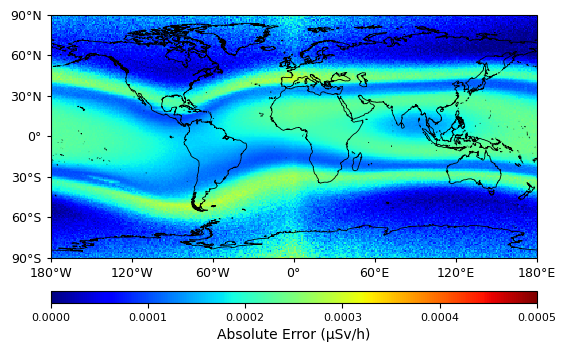

In [82]:
plot_field_region(
    lon_grid, lat_grid, np.abs((targ_img - pred_img)), i=idx_50pct_ssim,
    #title=f"test {date} - Error Map",
    units_label="Absolute Error (µSv/h)",
    region_extent=[-180, 180, -90, 90],
    vmin=0, vmax=5E-4,
    tick_step=(60, 30),
    #add_contour=True, contour_levels=np.linspace(0.025, 0.040, 5),
    mark_equator_meridian=False,
    show_borders=False,
    cmap= 'jet',
    #savepath='analysis/forecasting/tron_error_global_50thpct.png'
)